#**La classification des panneaux de signalisation sur le dataset GTSRB**


## --> Etapes de la Classification des Panneaux de Signalisation :


1.   Chargement et Prétraitement des Données :

*   Description : Charger le dataset GTSRB, redimensionner les images et normaliser les données.
*   Contenu :
 *   Lecture des fichiers CSV contenant les étiquettes et les chemins des images.
 *   Utilisation de cv2 et PIL pour lire et redimensionner les images.
 *   Normalisation des images en divisant par 255.

2.   Création d'un Modèle CNN Simple :

*   Description : Développer un modèle CNN de base pour la classification initiale avec des images de dimension (30, 30, 3).
*   Contenu :
 *   Définition d'un modèle CNN avec quelques couches de convolution et de pooling.
 *   Compilation du modèle avec une fonction de perte et un optimiseur approprié.
 *   Entraînement du modèle sur le dataset redimensionné.

3.   Développement d'un Modèle CNN Inspiré de VGG16 :

*   Description : Améliorer la performance en utilisant une architecture inspirée de VGG16, avec des images redimensionnées à (64, 64, 3).
*   Contenu :
 *   Définition d'un modèle CNN basé sur l'architecture VGG16, incluant des couches de convolution, des couches de pooling et des couches entièrement connectées.
Compilation du modèle avec une fonction de perte et un optimiseur approprié.
 *   Ajout de la batch normalization pour stabiliser et accélérer l'entraînement.
 *   Intégration d'un mécanisme d'attention pour améliorer la focalisation du modèle sur les parties importantes des images.

4.   Entraînement des Modèles et Optimisation :

*   Description : Entraîner les deux modèles sur le dataset GTSRB et optimiser leurs hyperparamètres.
*   Contenu :
 *   Utilisation de la technique d'early stopping pour éviter le surentraînement.
 *   Ajustement du taux d'apprentissage à l'aide de callbacks comme ReduceLROnPlateau.
 *   Sauvegarde du meilleur modèle en termes de performance sur les données de validation.

5.   Évaluation des Modèles :

*   Description : Évaluer les performances des modèles sur un jeu de données de test et visualiser les résultats.
*   Contenu :
 *   Calcul de l'accuracy et d'autres métriques de performance.
 *   Génération de la matrice de confusion et du rapport de classification.
 *   Visualisation des prédictions avec des images annotées pour comparer les étiquettes réelles et prédictions.

6.   Visualisation des Résultats :

*   Description : Visualiser les résultats de classification pour comprendre les erreurs et les performances du modèle.
*   Contenu :
 *   Affichage des images de test avec leurs étiquettes réelles et prédictions, en mettant en évidence les erreurs avec des couleurs distinctives.
 *   Tracer les courbes de perte et d'accuracy pour l'entraînement et la validation.

In [ ]:
# Liaison du drive et colab pour accéder au dataset GTSRB

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# importer les librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
os.chdir('/content/drive/MyDrive/Kaggle/GTSRB_data/GTSRB_DATA') # le chemin vers le dataset GTSRB
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

import tensorflow as tf
from keras import layers, models, datasets
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from keras.optimizers import Adam
from keras.optimizers import legacy
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from matplotlib import style
style.use('fivethirtyeight')

In [ ]:
data_dir = '/content/drive/MyDrive/Kaggle/GTSRB_data/GTSRB_DATA'
train_path = 'Train'
test_path = 'Test'

# Redimensionner les images en 30x30x3 pour le CNN normal
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

# le nombre de classes dans le dataset GTSRB
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
# donner un nom a chaque classe

classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

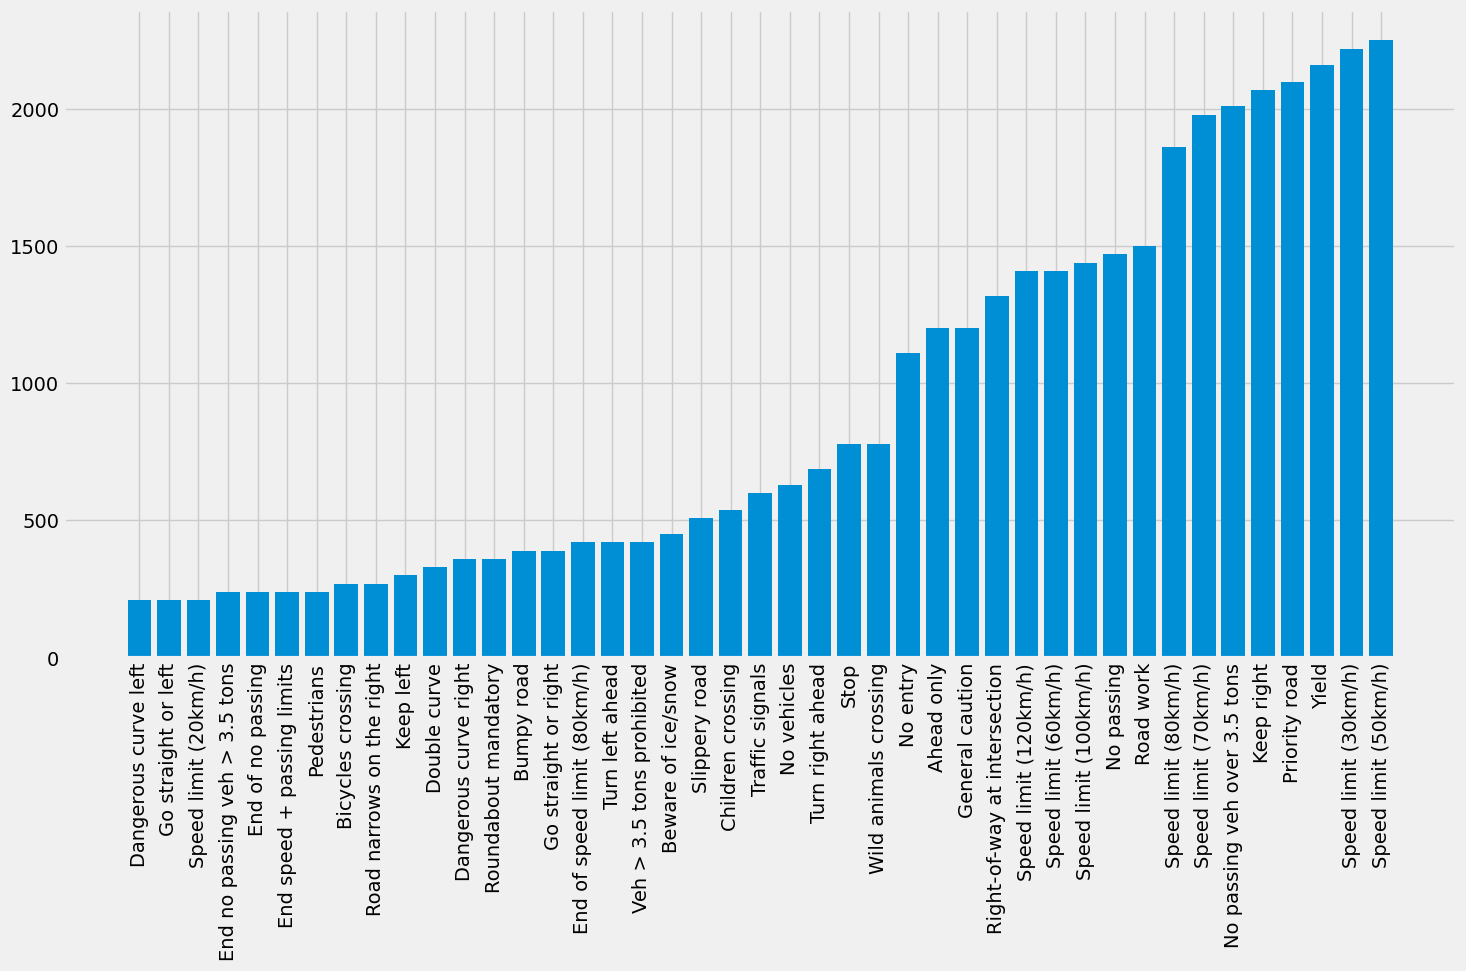

In [ ]:
# Histograme pour visualiser chaque classe et la valeur d'images contient

folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(16,8))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

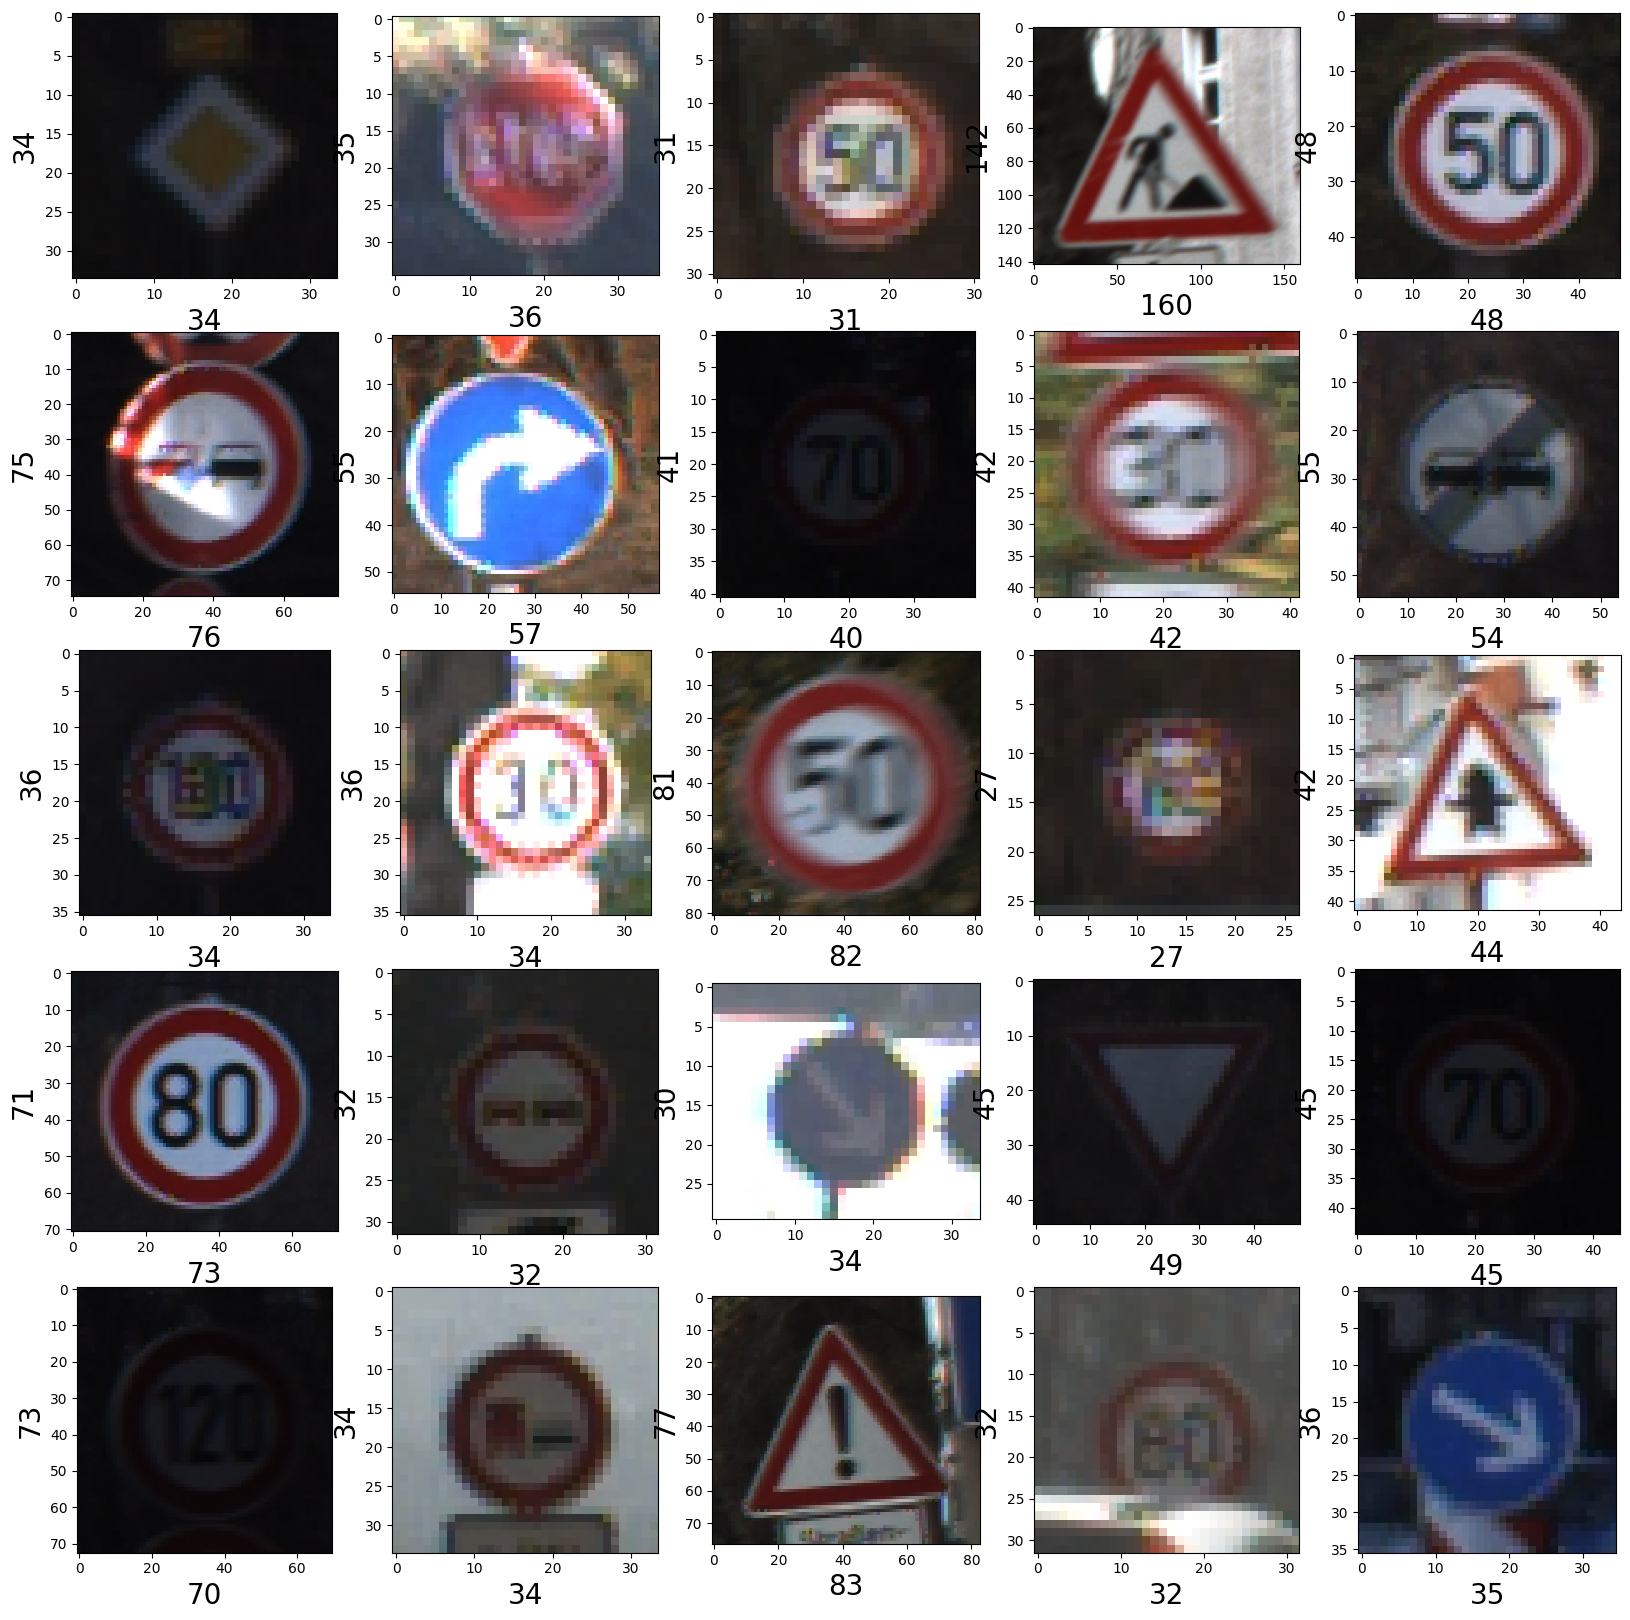

In [ ]:
# Visualiser 25 images aléatoires du l'ensemble du test data

import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(20,20))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    #plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [ ]:
# collecter les donnees d'entrainement et les redimensionnées en (30, 30, 3)


image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

'\nimage_data = []\nimage_labels = []\n\nfor i in range(NUM_CATEGORIES):\n    path = data_dir + \'/Train/\' + str(i)\n    images = os.listdir(path)\n\n    for img in images:\n        try:\n            image = cv2.imread(path + \'/\' + img)\n            image_fromarray = Image.fromarray(image, \'RGB\')\n            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))\n            image_data.append(np.array(resize_image))\n            image_labels.append(i)\n        except:\n            print("Error in " + img)\n'

In [ ]:
# creer un dossier trainng et stocker les donnees normalisees

os.mkdir('training')

np.save('./training/data',image_data)
np.save('./training/target',image_labels)'''

"\nos.mkdir('training')\n\nnp.save('./training/data',image_data)\nnp.save('./training/target',image_labels)"

#DATA (30, 30, 3)

In [ ]:
# télécheger ce fichier

image_data=np.load('./training/data.npy')
image_labels=np.load('./training/target.npy')


In [ ]:
image_data.shape

(39209, 30, 30, 3)

In [ ]:
# Changer les listes en numpy array

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [ ]:
# Mélanger les données d'entraînement

shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
# Diviser les données en train et ensemble de validation

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [ ]:
# one hot encoding les labels

y_train = to_categorical(y_train, NUM_CATEGORIES)
y_val = to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


#Modèle 1 : CNN simple

## --> Dans cette partie j'ai crée un simple CNN pour le test sur le dataset GTSRB et voir le resultat et j'ai obtenu 98,60% en accuracy

In [ ]:
import tensorflow as tf
from keras import layers, models, datasets
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.optimizers import legacy
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import style
style.use('fivethirtyeight')

In [ ]:
# le modèle CNN simple

model = models.Sequential([
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),

    layers.Dense(43, activation='softmax')
])

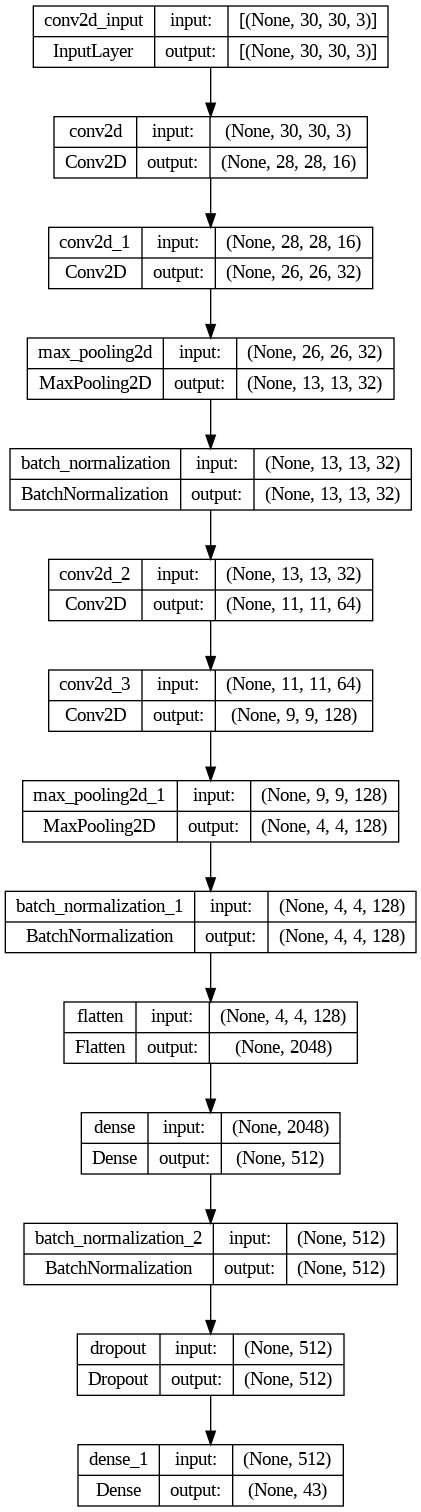

In [ ]:
# la structure du modèle

tf.keras.utils.plot_model(model,show_shapes=True)

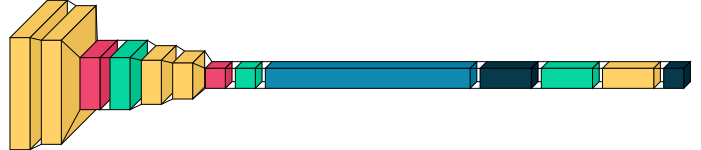

In [ ]:
# les couches du modèle

import visualkeras
visualkeras.layered_view(model)

### Entrainement du modèle


In [ ]:
# les paramètres de l'entrainement

lr = 0.001
epochs = 30

opt = legacy.Adam(lr=lr, decay=lr / (epochs * 0.5))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Augmenter les données et les entrainées

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 103s 119ms/step - loss: 1.0861 - accuracy: 0.7079 - val_loss: 0.1367 - val_accuracy: 0.9566
Epoch 2/30
858/858 [==============================] - 100s 116ms/step - loss: 0.1785 - accuracy: 0.9469 - val_loss: 0.0541 - val_accuracy: 0.9845
Epoch 3/30
858/858 [==============================] - 100s 117ms/step - loss: 0.1084 - accuracy: 0.9662 - val_loss: 0.0260 - val_accuracy: 0.9931
Epoch 4/30
858/858 [==============================] - 102s 119ms/step - loss: 0.0759 - accuracy: 0.9783 - val_loss: 0.0176 - val_accuracy: 0.9947
Epoch 5/30
858/858 [==============================] - 97s 112ms/step - loss: 0.0664 - accuracy: 0.9790 - val_loss: 0.0591 - val_accuracy: 0.9808
Epoch 6/30
858/858 [==============================] - 102s 119ms/step - loss: 0.0582 - accuracy: 0.9818 - val_loss: 0.0167 - val_accuracy: 0.9951
Epoch 7/30
858/858 [==============================] - 103s 119ms/step - loss: 0.0468 - accuracy: 0.9858 - val_loss: 0.0084 - 

### Visualisation des résultats

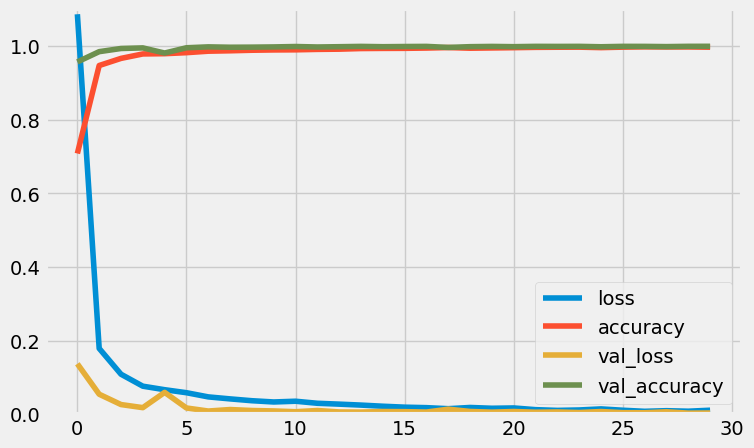

In [ ]:
# évaluer le modèle

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.show()

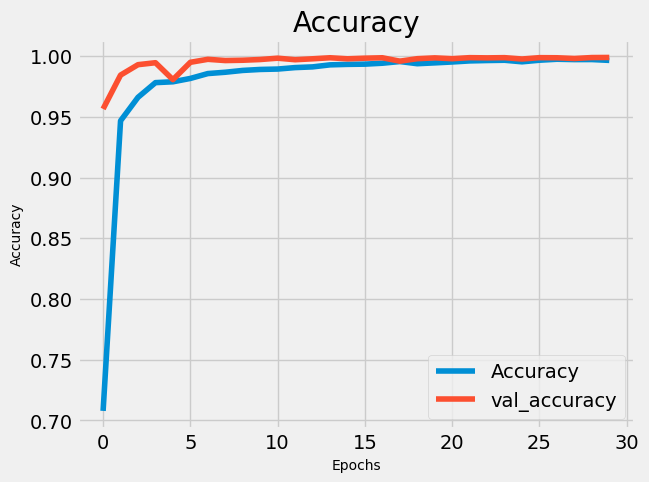

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.legend(['Accuracy','val_accuracy'])
plt.grid(True)

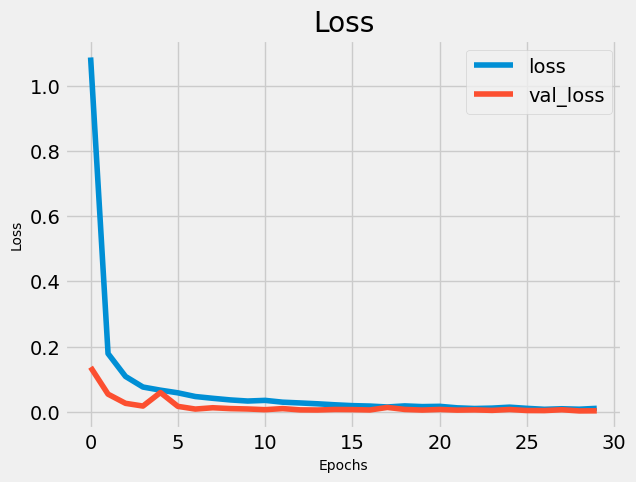

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.grid(True)

### Evaluation

<Axes: >

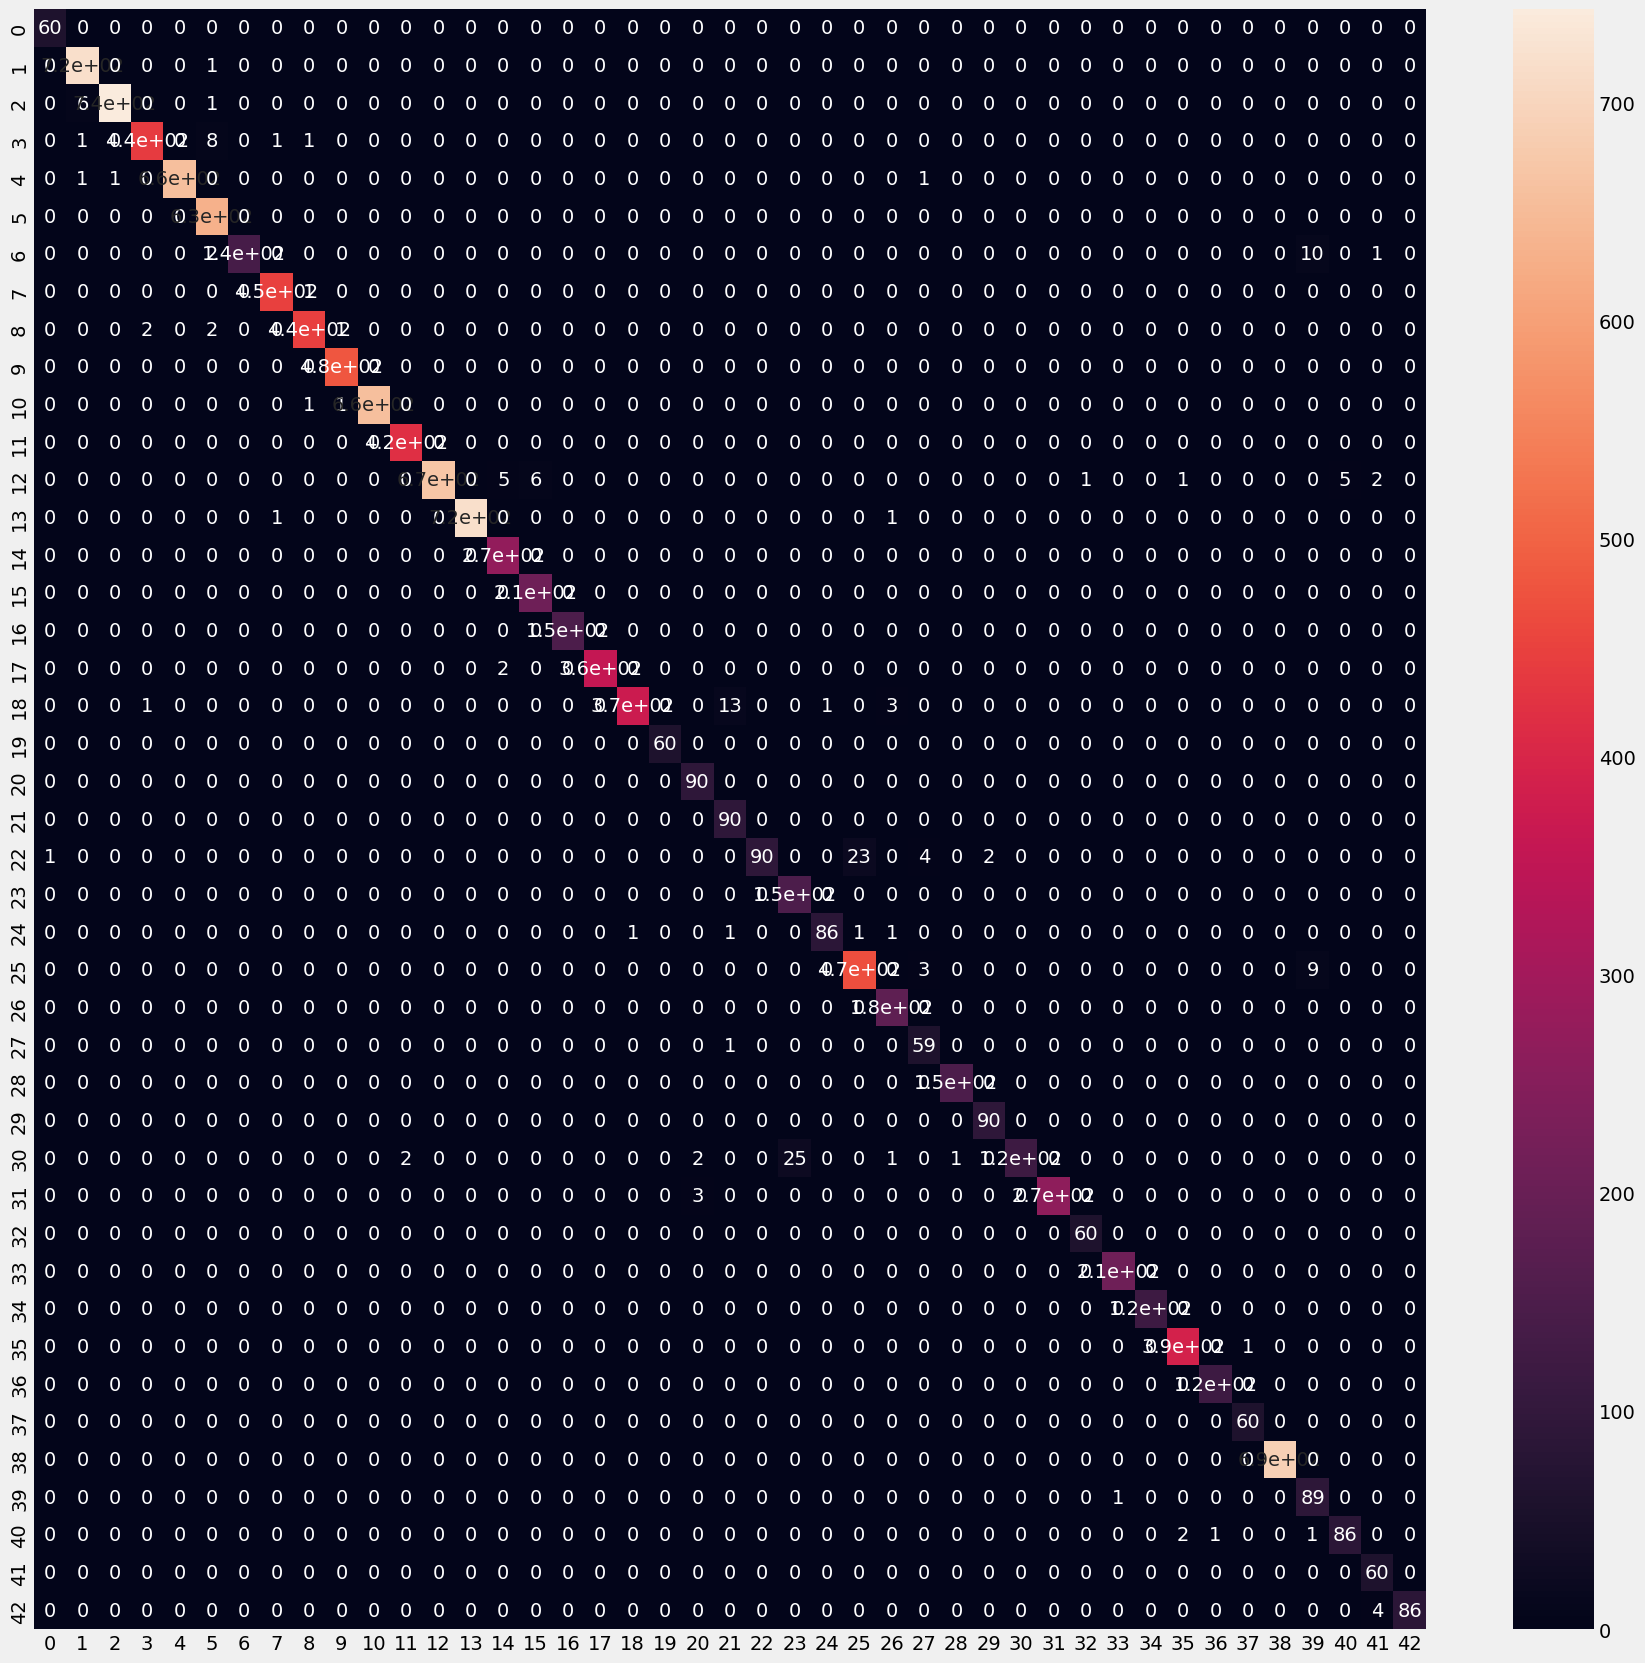

In [ ]:
# évaluer la performance du modèle à l'aide de la matrice de confusion

import seaborn as sns
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(labels, pred)
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
# évaluation détaillée de la performance du modèle à l'aide de la classification report qui porte sur chaque classe

from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       1.00      0.99      0.99       750
           3       0.99      0.98      0.98       450
           4       1.00      1.00      1.00       660
           5       0.98      1.00      0.99       630
           6       1.00      0.91      0.95       150
           7       1.00      1.00      1.00       450
           8       0.99      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       0.97      1.00      0.99       270
          15       0.97      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [ ]:
#  parcourir les données du test et les redimensionnées

from sklearn.metrics import accuracy_score

test = pd.read_csv(data_dir + '/Test.csv')
labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# L'évaluation

pred = np.argmax(model.predict(X_test), axis=1)
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 9s 24ms/step
Test Data accuracy:  98.60649247822644


In [ ]:
# créer un dossier testing et stocker les données normalisées


os.mkdir('testing')

np.save('./testing/data',X_test)

# télécheger ce fichier

X_test=np.load('./testing/data.npy')

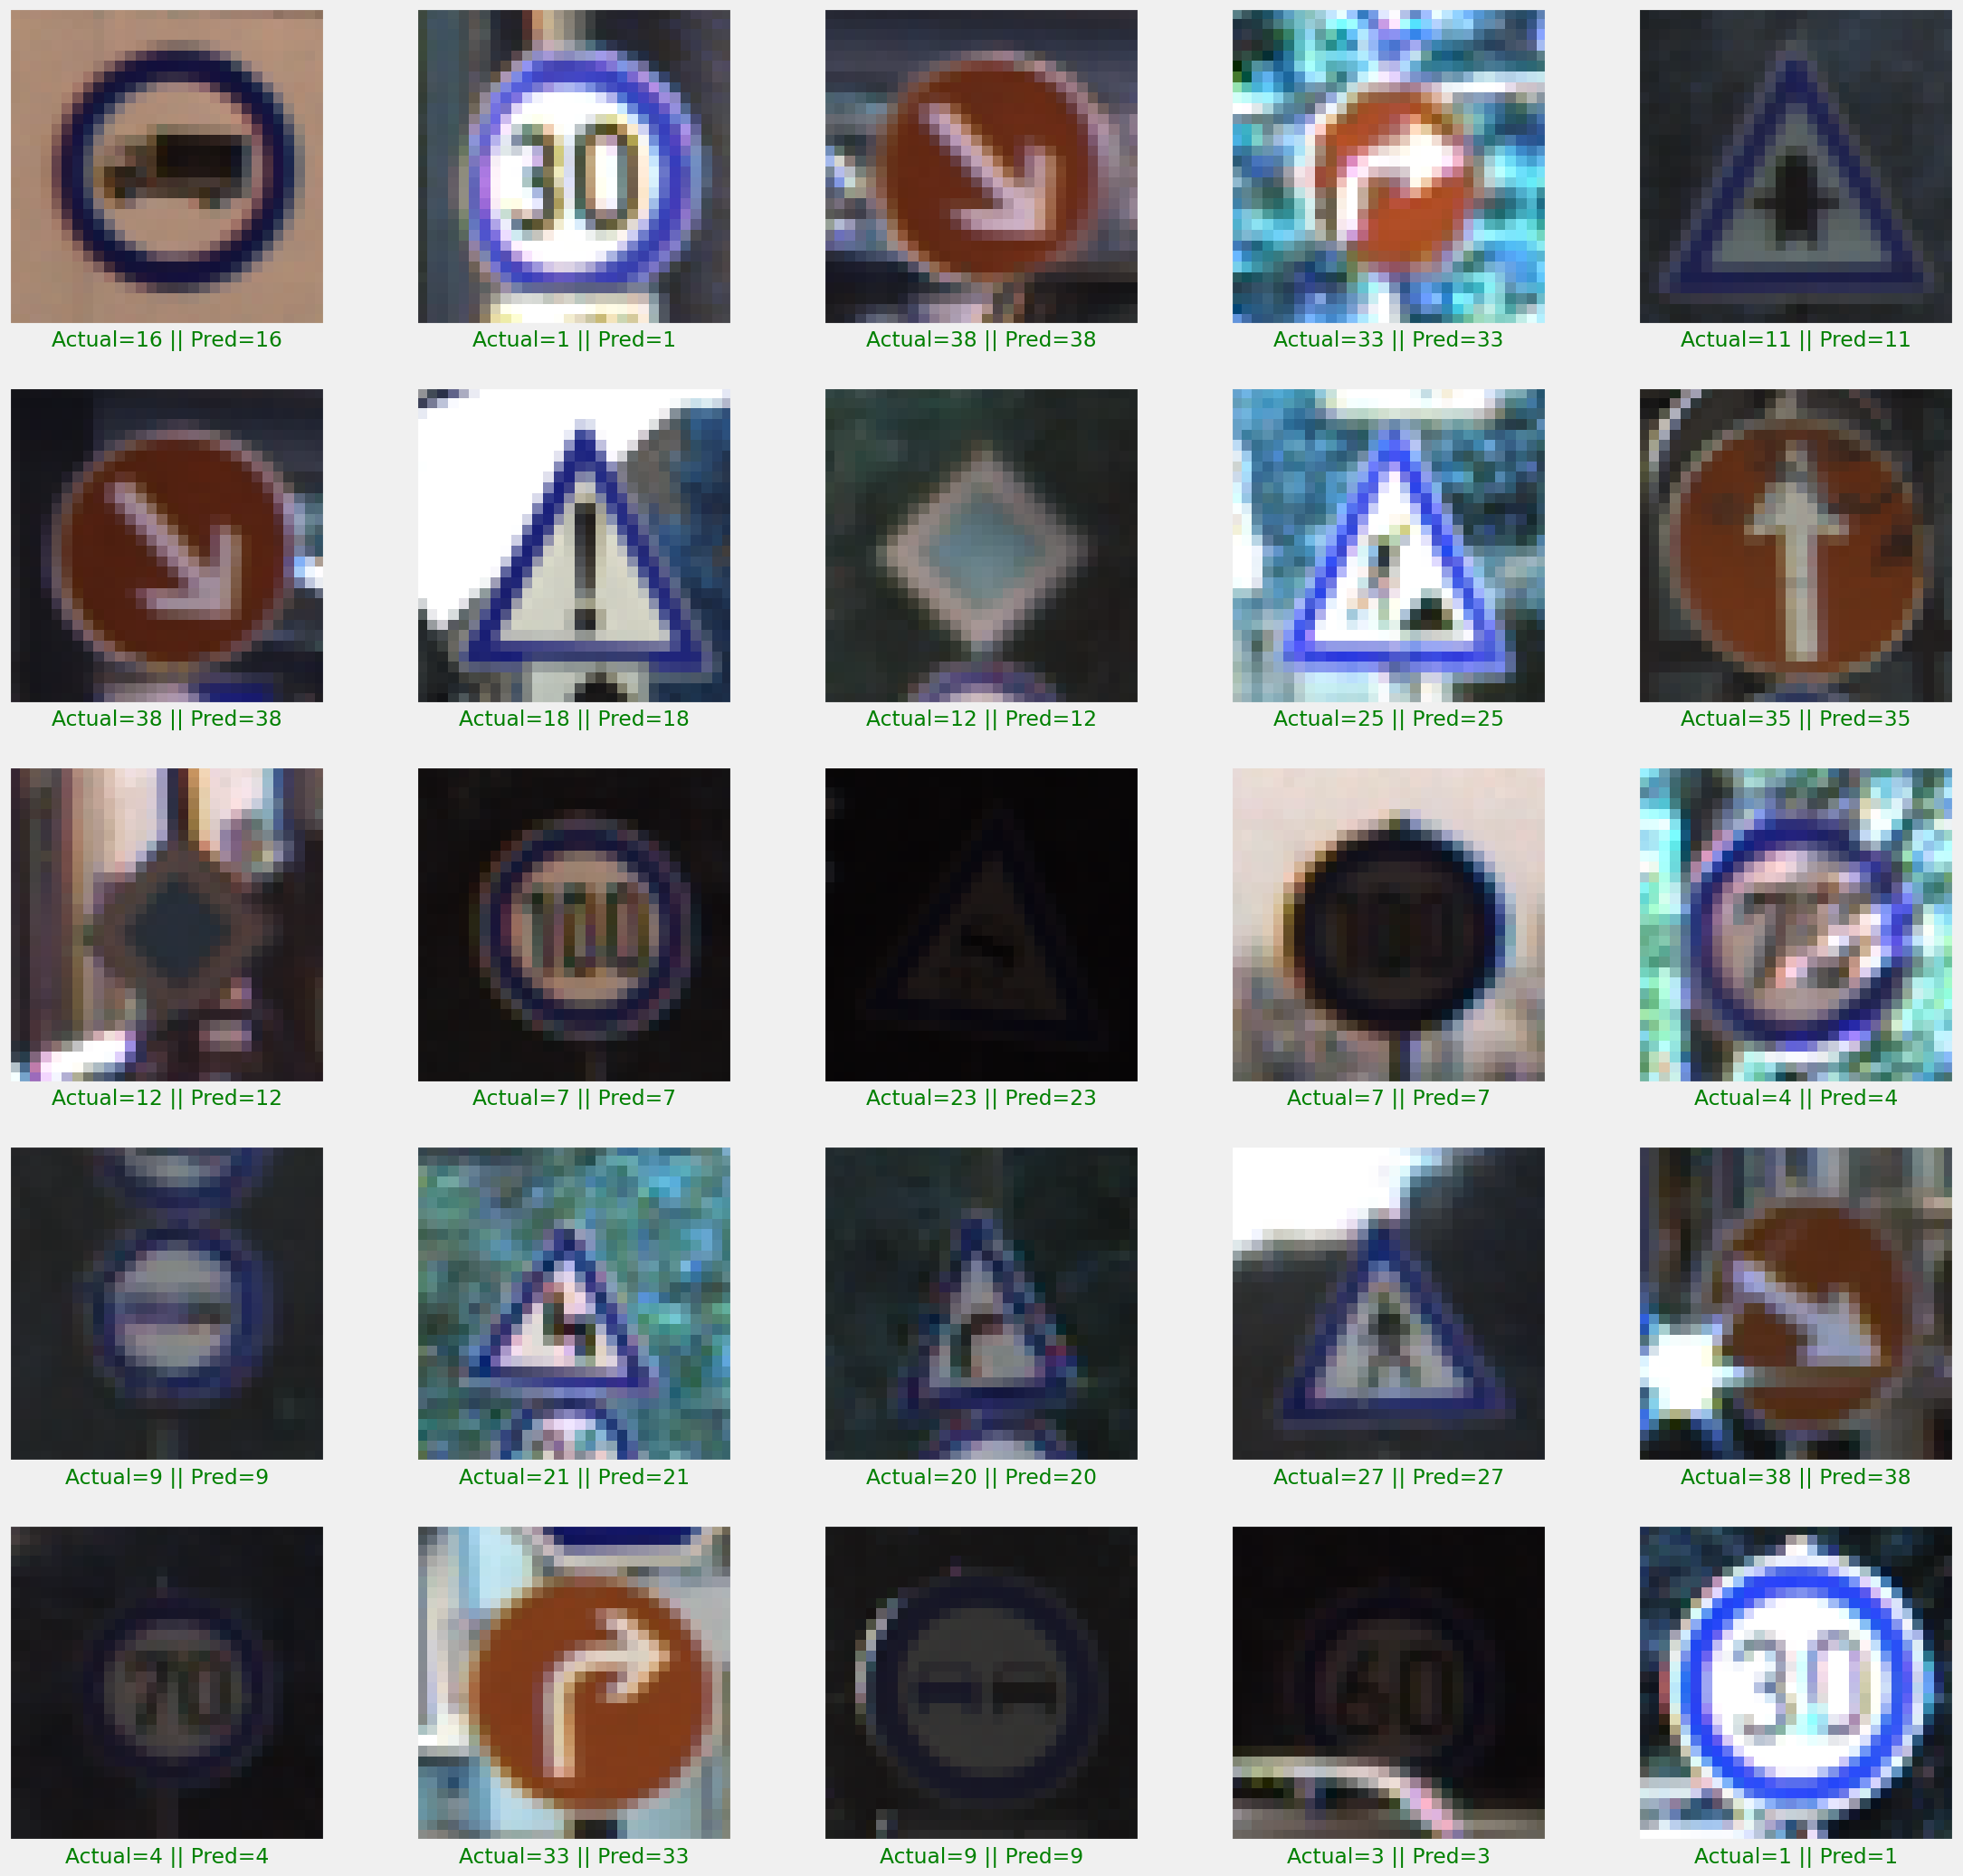

In [ ]:
#  Visualisation des Prédictions et des Étiquettes Réelles pour les Images de Test

plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
# télécharger le modèle

import h5py

model.save('CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


####################################################################################################

# DATA (64, 64, 3)

In [ ]:
# collecter les donnees d'entrainement et les redimensionnées en (64, 64, 3)


image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((64, 64))
            # gray_img = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY) # on peut utiliser ces deux lignes pour convertir les images en gris
            # image_data.append(np.array(gray_img))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)


# creer un dossier trainng et stocker les donnees normalisees

In [ ]:
os.mkdir('train64')

In [ ]:

np.save('./train64/data',image_data)
np.save('./train64/target',image_labels)

In [ ]:
# télécheger ce fichier

image_data=np.load('./train64/data.npy')
image_labels=np.load('./train64/target.npy')

In [ ]:
# Changer les listes en numpy array

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

In [ ]:
# Mélanger les données d'entraînement

shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
# Diviser les données en train et ensemble de validation

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

In [ ]:
# one hot encoding les labels

y_train = to_categorical(y_train, NUM_CATEGORIES)
y_val = to_categorical(y_val, NUM_CATEGORIES)
print(y_train.shape)
print(y_val.shape)

(39209, 64, 64, 3) (39209,)
X_train.shape (27446, 64, 64, 3)
X_valid.shape (11763, 64, 64, 3)
y_train.shape (27446,)
y_valid.shape (11763,)
(27446, 43)
(11763, 43)


#Modèle 2 :  Mon modèle (VGG16 amélioré avec méchanisme d'attention)


## --> Dans cette partie j'ai crée un modèle (VGG16 amélioré qui contient Batch-Normalisatiion avec méchanisme d'attention) sur le dataset GTSRB et voir le résultat et j'ai obtenu 99,24% en accuracy



In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Multiply, GlobalAveragePooling2D
from keras.models import Model

def vgg16_with_multi_scale_feature_fusion_and_attention(input_shape, num_classes):
    # Entrée du modèle
    inputs = Input(shape=input_shape)

    # Bloc convolutif 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Bloc convolutif 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Bloc convolutif 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Fusion de caractéristiques à plusieurs échelles
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Mécanisme d'attention du canal
    attention = GlobalAveragePooling2D()(x)
    attention = Dense(512, activation='relu')(attention)
    attention = Dense(512, activation='sigmoid')(attention)
    attention = Multiply()([x, attention])

    # Bloc convolutif 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(attention)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Bloc convolutif 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Couches fully connected
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Définition des dimensions d'entrée et du nombre de classes
input_shape = (64, 64, 3)
num_classes = 43

# Création du modèle VGG16 amélioré avec fusion de caractéristiques à plusieurs échelles et mécanisme d'attention du canal
model = vgg16_with_multi_scale_feature_fusion_and_attention(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['batch_normalization[0][0

In [ ]:
# Définir les callbacks pour le modèle checkpoint, reduce learning rate et early stopping, qui aide le modèle pour performer bien



checkpoint = ModelCheckpoint("./model/best_cnn_attention_flower3.h5",
                             monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=5,
                              min_lr=0)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=15, verbose=1,
                               restore_best_weights=True,
                               mode='max')

### Entrainement du modèle

In [ ]:
# Entrainer le modèle en utilisant callbacks

import timeit
start_time = timeit.default_timer()


aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


# Train the model
history = model.fit(aug.flow(X_train, y_train, batch_size=32),
   epochs=100,
   validation_data=(X_val, y_val),
  callbacks=[checkpoint,reduce_lr,early_stopping]  # Use the checkpoint to save the best model
)
elapsed = timeit.default_timer() - start_time
print("Total time: ", elapsed, "seconds")


Epoch 1/100
858/858 [==============================] - ETA: 0s - loss: 2.6968 - accuracy: 0.2299
Epoch 1: val_accuracy improved from -inf to 0.32662, saving model to ./model/best_cnn_attention_flower3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


858/858 [==============================] - 115s 116ms/step - loss: 2.6968 - accuracy: 0.2299 - val_loss: 2.1001 - val_accuracy: 0.3266 - lr: 0.0010
Epoch 2/100
858/858 [==============================] - ETA: 0s - loss: 1.5293 - accuracy: 0.4727
Epoch 2: val_accuracy improved from 0.32662 to 0.57298, saving model to ./model/best_cnn_attention_flower3.h5
858/858 [==============================] - 113s 132ms/step - loss: 1.5293 - accuracy: 0.4727 - val_loss: 1.2491 - val_accuracy: 0.5730 - lr: 0.0010
Epoch 3/100
858/858 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.7323
Epoch 3: val_accuracy improved from 0.57298 to 0.90955, saving model to ./model/best_cnn_attention_flower3.h5
858/858 [==============================] - 128s 149ms/step - loss: 0.7716 - accuracy: 0.7323 - val_loss: 0.2562 - val_accuracy: 0.9095 - lr: 0.0010
Epoch 4/100
858/858 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9217
Epoch 4: val_accuracy improved from 0.90955 t

In [ ]:
from keras.models import load_model

# Charger le meilleur modèle sauvegardé

model = load_model('./model/best_cnn_attention_flower3.h5')

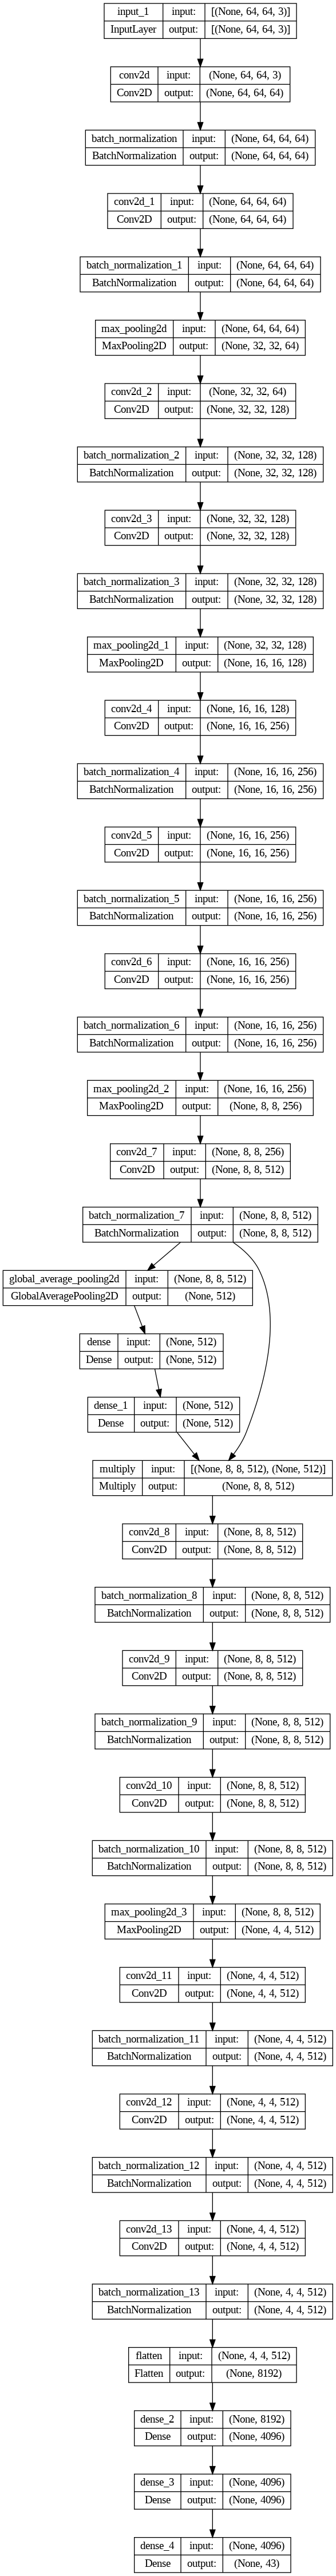

In [ ]:
# voir la structure du modèle

tf.keras.utils.plot_model(model,show_shapes=True)

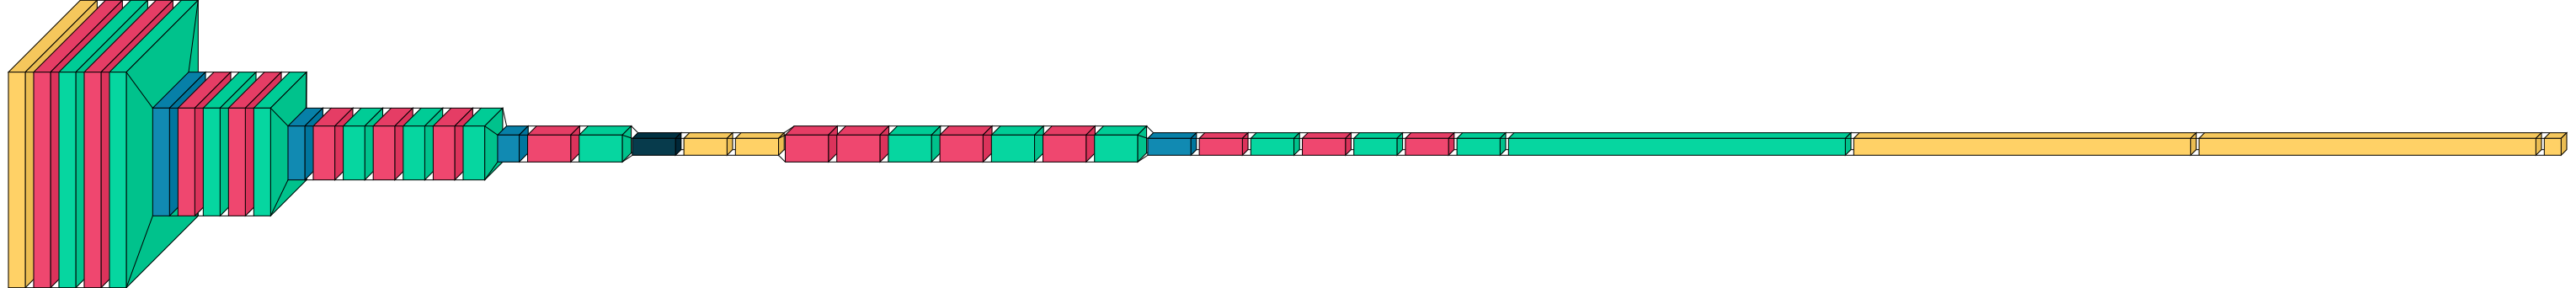

In [ ]:
# Voir la structure du modèle

import visualkeras
visualkeras.layered_view(model)

## Visualisation des résultats

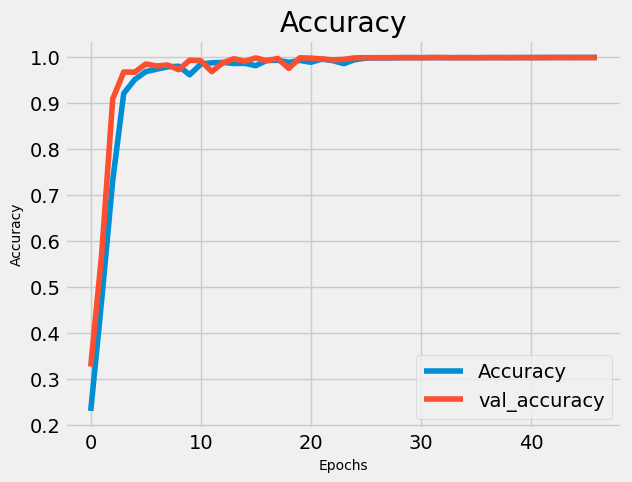

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.legend(['Accuracy','val_accuracy'])
plt.grid(True)

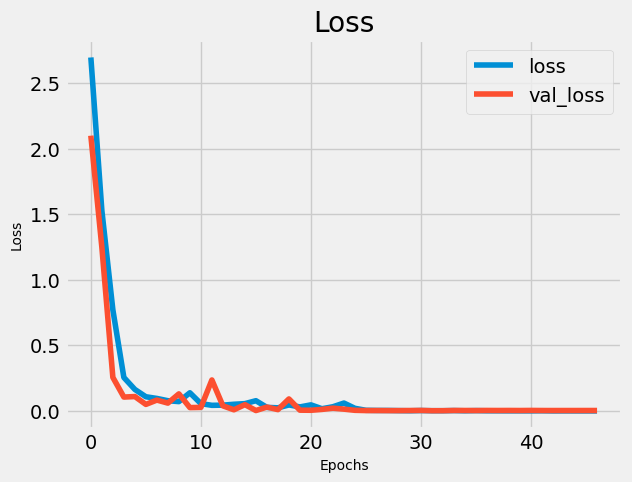

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.grid(True)

## Evaluation

<Axes: >

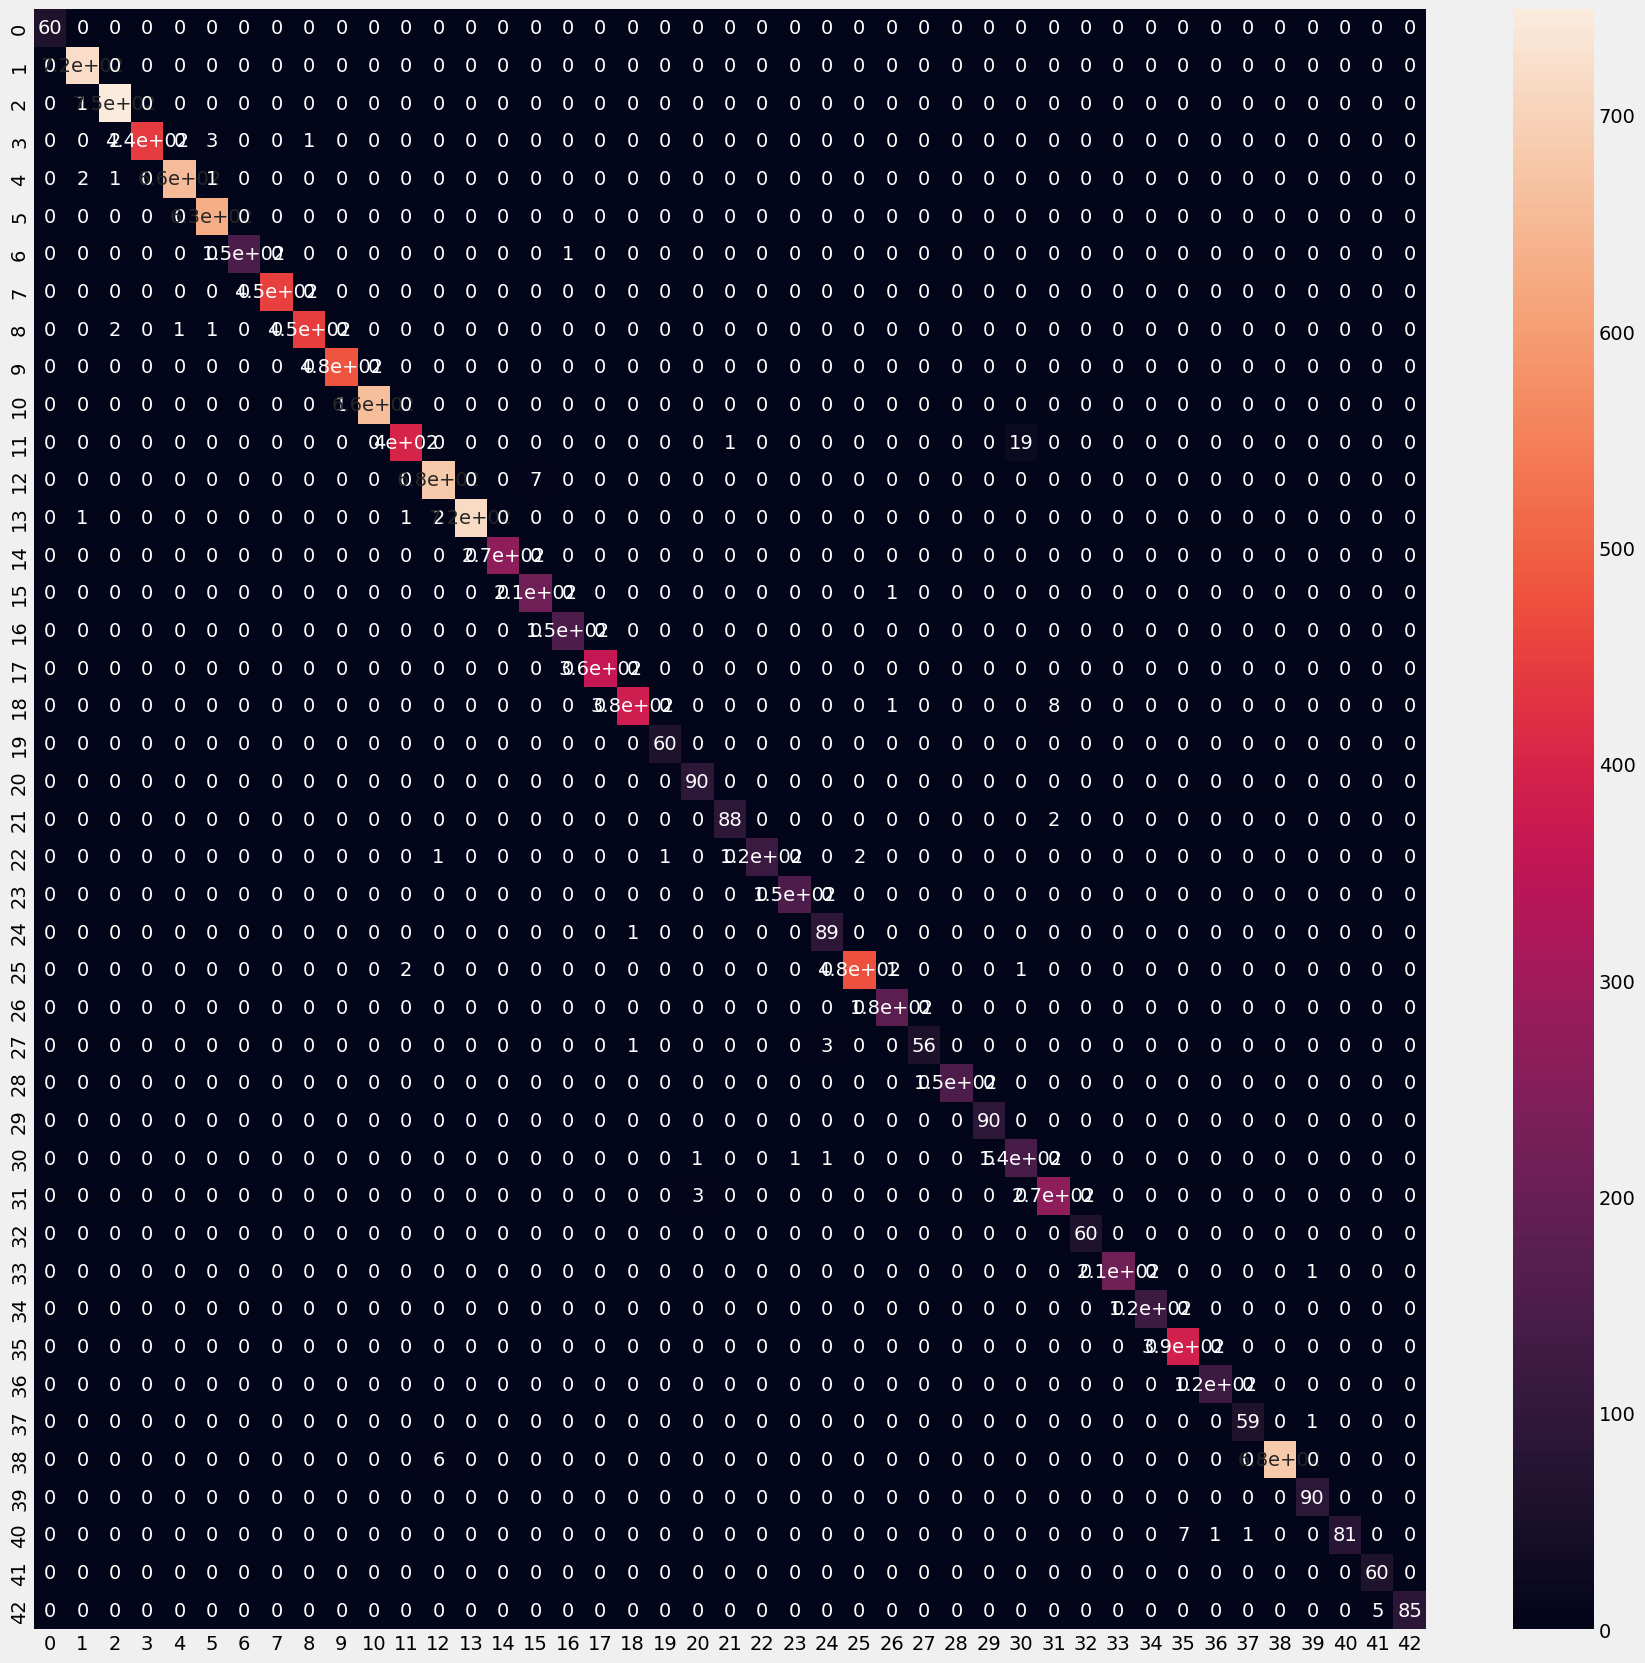

In [ ]:
# évaluer la performance du modèle à l'aide de la matrice de confusion

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
# évaluation détaillée de la performance du modèle à l'aide de la classification report qui porte sur chaque classe

from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      1.00       750
           3       1.00      0.99      0.99       450
           4       1.00      0.99      1.00       660
           5       0.99      1.00      1.00       630
           6       1.00      0.99      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.95      0.97       420
          12       0.99      0.99      0.99       690
          13       1.00      0.99      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [ ]:
#  parcourir les données du test et les redimensionnées

test = pd.read_csv(data_dir + '/Test.csv')
labels = test["ClassId"].values
imgs = test["Path"].values

batch_size = 1000  # Vous pouvez ajuster la taille du lot
num_batches = len(imgs) // batch_size + (1 if len(imgs) % batch_size != 0 else 0)

#  pour redimensionner le dataset du test en (64, 64, 3)

data = []
for batch in range(num_batches):
    batch_imgs = imgs[batch * batch_size:(batch + 1) * batch_size]
    batch_data = []
    for img in batch_imgs:
        try:
            image = cv2.imread(data_dir + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((64, 64))
            batch_data.append(np.array(resize_image))
        except:
            print("Error in " + img)
    data.extend(batch_data)

X_test = np.array(data)
X_test = X_test / 255


# évaluation
pred = np.argmax(model.predict(X_test), axis=1)
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 755s 2s/step
Test Data accuracy:  99.24782264449723


In [ ]:
# créer un dossier testing et stocker les donnees normalisees


os.mkdir('testing64')

np.save('./testing64/data',X_test)

In [ ]:
# télécharger le dataset du test déjà enregistrer

X_test=np.load('./testing64/data.npy')

In [ ]:
# Obtenir le learning rate final choisi


final_lr = model.optimizer.learning_rate.numpy()
print(f'Final learning rate: {final_lr}')

Final learning rate: 4.0000002627493814e-05


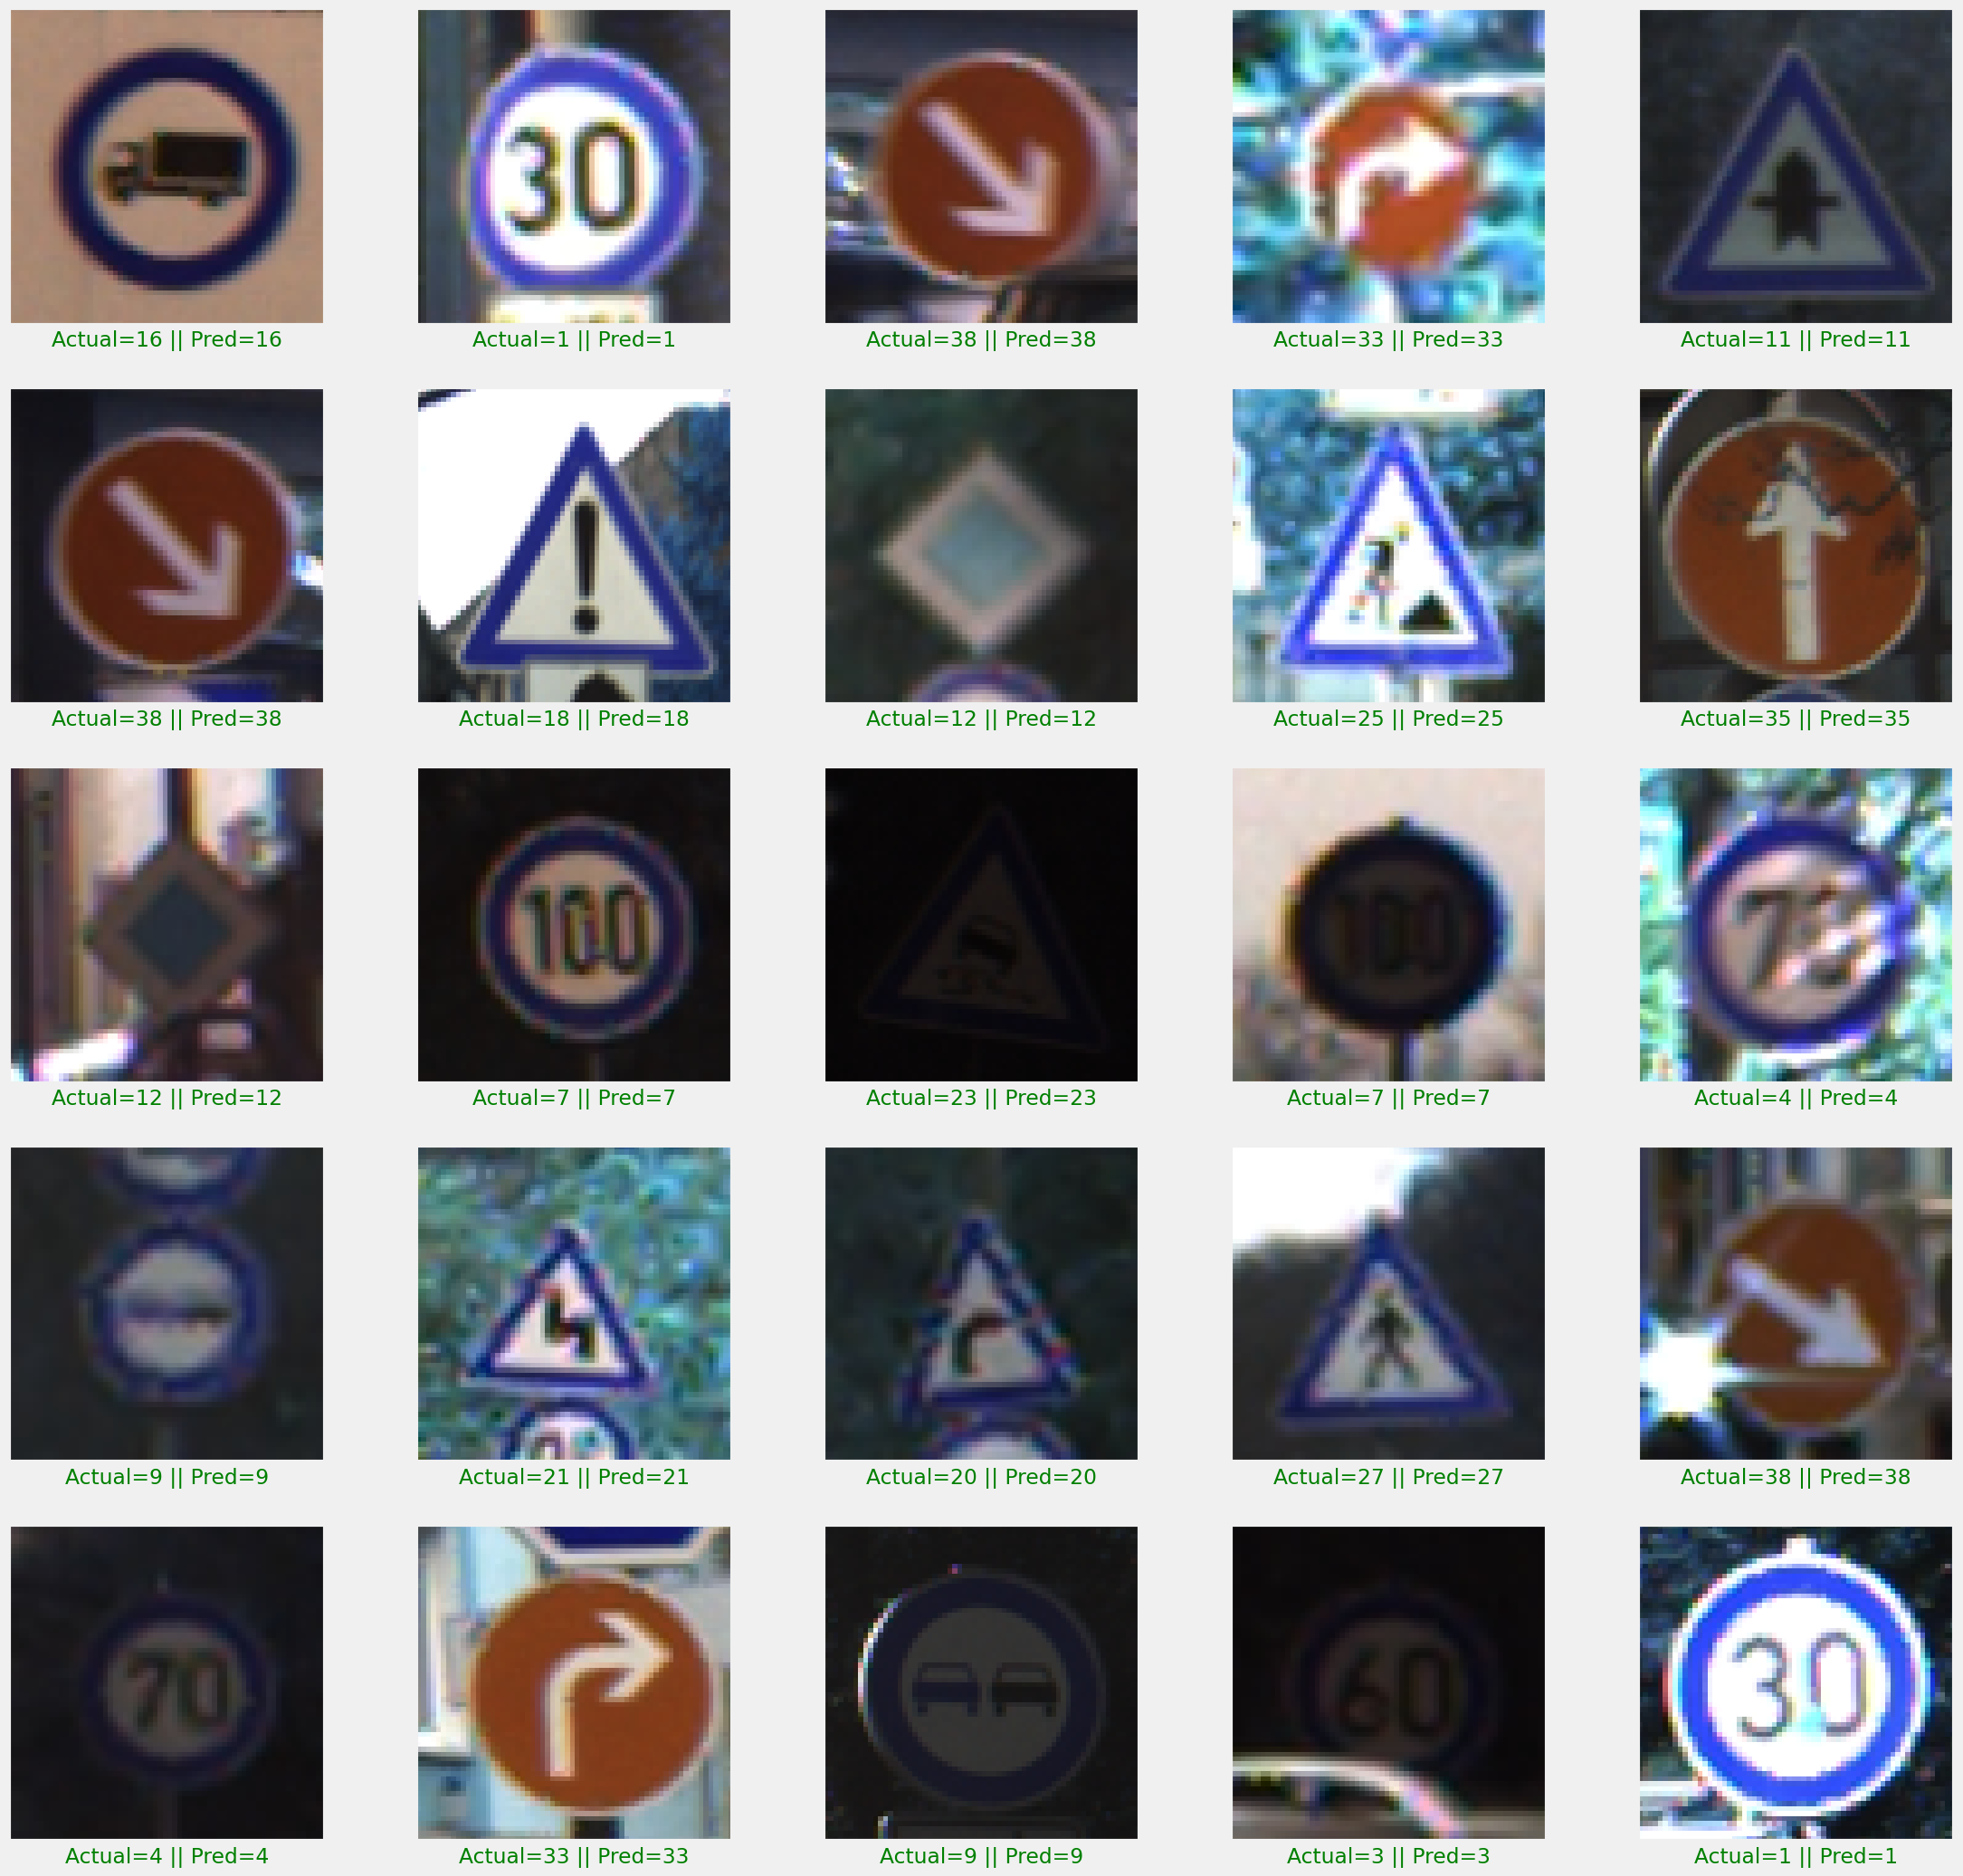

In [ ]:
#  Visualisation des Prédictions et des Étiquettes Réelles pour les Images de Test

plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()